### Connect to thymio

In [1]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node d7c91586-507b-4962-bc0c-0fab87b9921b

### Disconnect

In [6]:
aw(node.unlock())

NameError: name 'aw' is not defined

### Test functions on Thymio

In [2]:
aw(node.lock())
# Create an event named speed, with a size of data of 2 (should be between 0-32)
aw(node.register_events([("update_motors", 2)]))

# The event data are obtained from variable event.args:
program = """
onevent update_motors
    motor.left.target = event.args[0]
    motor.right.target = event.args[1]
"""
aw(node.compile(program))
aw(node.run())

In [3]:
# turn right
aw(node.send_events({"update_motors": [40, 20]}))
# wait 1 second
aw(client.sleep(1))
# stop the robot
aw(node.send_events({"update_motors": [0, 0]}))

### Inports

In [4]:
import time
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import motion_control as mc
from motion_control import Trajectory
from motion_control import Node
from motion_control import MotionControl

### Simulate functions from <code>motion_control.py</code>

In [9]:
#________________________________vvv inputs vvv________________________________#

opt_traj = Trajectory([Node(0,0,0),
                       Node(1,0,20),
                       Node(2,20,20),
                       Node(3,20,40)])

robot_x, robot_y = 100, 100
robot_ang = 0
#________________________________^^^ inputs ^^^________________________________#

In [19]:
def speed_to_pos(x, y, ls, rs, ang, dt):
    '''
    Determines the next position in time using the speed of the wheels and the current position
    Inputs:
        x,y - the actual postion of the robot [cm]
        ls, rs - the measured speed of the left and right wheels [aseba unit]
        ang - the actual orientation of the robot [rad]
        dt - the delta time [sec]
    Outputs:
        new_x = x + dx [cm]
        new_y = y + dy [cm]
        new_ang = ang + dang [rad]
    '''
    
    robot_width = 9.4 #[cm]
    speed_ratio = 10.6 #i've tuned this parameter in order to be as close as possible to reality
    
    l_dist = dt*ls/speed_ratio    # distance done by the left wheel
    l_ang = l_dist/robot_width    # angle done by the left wheel if right wheel is stopped
    r_dist = dt*rs/speed_ratio    # same
    r_ang = r_dist/robot_width    # same
    
    #forward
    df_l = robot_width/2 * np.sin(l_ang)    # compute the displacement done forward if only the left wheel is moving
    df_r = robot_width/2 * np.sin(r_ang)    # same for right wheel
    df = df_l + df_r                        # the total one is the sum of the two
    
    #side
    ds_l = -robot_width/2 * (1-np.cos(l_ang))    # compute the displacement on the side if only the left is moving
    ds_r =  robot_width/2 * (1-np.cos(r_ang))    # same for right
    ds = ds_l + ds_r                             # total side displacement is the sum of the two
    
    dang = -l_ang + r_ang                     # the change in angle is the angle done by right wheel - angle done by left wheel
    dx = np.cos(ang) * df + np.sin(ang) * ds  # the change in x direction depends on the angle of the robot
    dy = np.sin(ang) * df + np.cos(ang) * ds  # the change in y depends on the angle of the robot as well
    
    NOISE = False
    # simulate noise
    if NOISE:
        dang = dang+dang*np.random.normal(0,1)
        dx = dx+dx*np.random.normal(0,1)
        dy = dy+dy*np.random.normal(0,1)
    
    return x+dx, y+dy, ang+dang

In [20]:
robot_x, robot_y, robot_ang = 0, 0, 0
mc = MotionControl(opt_traj, robot_x, robot_y, robot_ang)

dt = 1/16
true_traj = []
while True:
    mc.update_global(robot_x, robot_y, robot_ang)
    true_traj.append(Node(0,mc.robot_pos.x, mc.robot_pos.y))
    robot_x, robot_y, robot_ang = speed_to_pos(robot_x, robot_y, mc.l_speed, mc.r_speed, mc.robot_ori, dt)
    aw(node.send_events({"update_motors": [int(mc.l_speed), int(mc.r_speed)]}))
    aw(client.sleep(dt))
#     print(mc.robot_pos.x, mc.robot_pos.y, mc.robot_ori)

    if (mc.l_speed == 0) & (mc.r_speed == 0):
        break

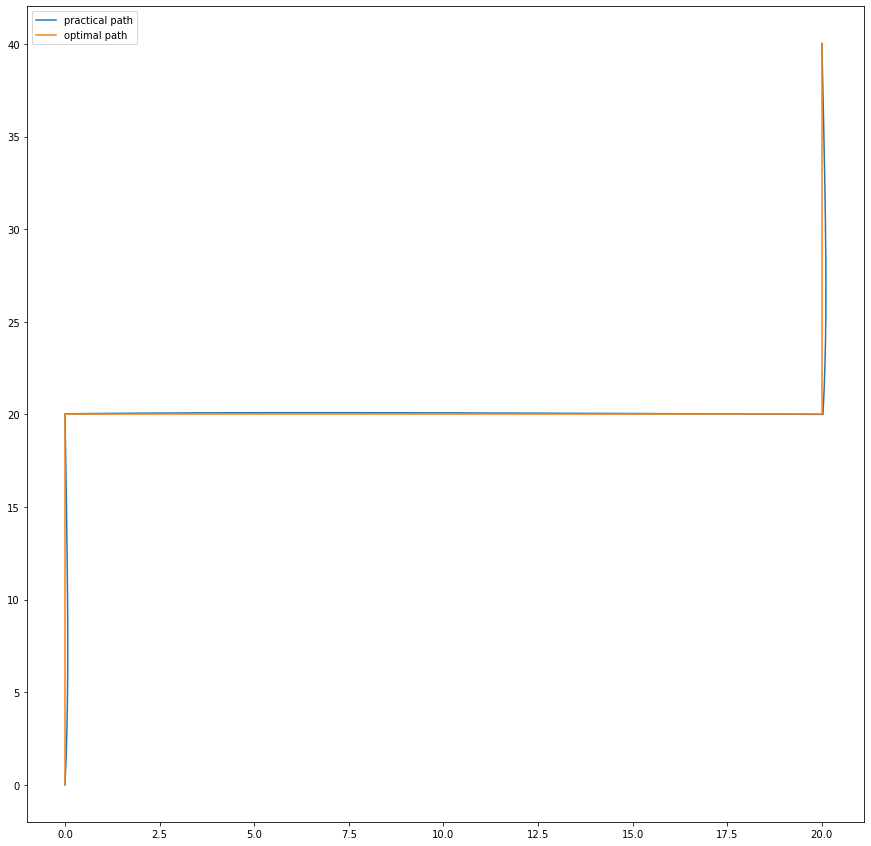

Exception in thread Thread-5:
Traceback (most recent call last):
  File "C:\Users\pujol\anaconda3\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "C:\Users\pujol\anaconda3\lib\site-packages\tdmclient\tcp.py", line 73, in run
    packet = self.read_packet()
  File "C:\Users\pujol\anaconda3\lib\site-packages\tdmclient\tcp.py", line 66, in read_packet
    raise error
  File "C:\Users\pujol\anaconda3\lib\site-packages\tdmclient\tcp.py", line 59, in read_packet
    packet_len = self.read_uint32()
  File "C:\Users\pujol\anaconda3\lib\site-packages\tdmclient\tcp.py", line 46, in read_uint32
    b = self.io.read(4)
  File "C:\Users\pujol\anaconda3\lib\site-packages\tdmclient\tcp.py", line 99, in read
    return self.socket.recv(n)
ConnectionResetError: [WinError 10054] Une connexion existante a dû être fermée par l’hôte distant


In [21]:
fig = plt.figure(figsize=(15,15))
x = np.array([point.x for point in mc.opt_traj.points])
y = np.array([point.y for point in mc.opt_traj.points])
x_true = np.array([point.x for point in true_traj])
y_true = np.array([point.y for point in true_traj])
plt.plot(x_true,y_true, label='practical path')
plt.plot(x,y, label = 'optimal path')
plt.legend()
plt.show()

In [ ]:
# aquire obstacles with vision
nodes, links = nodes_from_vision()

# compute best path with nodes
opt_traj = algo_path(nodes, links)

# initial robot position
robot_pos_ini = pos_estim_kalman(vision)

# create a MotionControl instance
mc = MotionControl(opt_traj, robot_pos_ini)

#everturning loop
while True:
    
    # aquire position of the robot with the filtering
    robot_pos = pos_estim_kalman(vision)
    
    # if reached the final node
    if robot_pos = goal_pos:
        thymio_lspeed, thymio_rspeed = 0, 0
        break
    
    # if encounters an obstacle and the robot is still far away from next point,
    # switches to local nav temporarly
    obstacle = prox.sensor & (dist_from_next_point > robot_size)
    if obstacle:
        nav = 'local'
        
    # if the robot is offtrack, it means there is a distance between it and the line joining the two points
    off_track = (distance_from_line(robot_pos, actual_point, next_point) > 0)
    # if the robot is on the track (on the line of the desired path, switches back to global)
    back_on_track = not(off_track)
    if back_on_track:
        nav = 'global'
        
    if nav == 'local':
        mc.update_local(prox.sensors)
        thymio_lspeed, thymio_rspeed = mc.lspeed, mc.rspeed
    else:
        mc.update_global(robot_pos)
        thymio_lspeed, thymio_rspeed = mc.lspeed, mc.rspeed
    